In [1]:
import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
import os
from collections import Counter
from imblearn.over_sampling import (SMOTE, ADASYN, BorderlineSMOTE, KMeansSMOTE, RandomOverSampler, SMOTENC, SVMSMOTE)
from imblearn.under_sampling import (ClusterCentroids, RandomUnderSampler,
                                     NearMiss,
                                     InstanceHardnessThreshold,
                                     CondensedNearestNeighbour,
                                     EditedNearestNeighbours,
                                     RepeatedEditedNearestNeighbours,
                                     AllKNN,
                                     NeighbourhoodCleaningRule,
                                     OneSidedSelection, TomekLinks)

In [6]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot as plt
% matplotlib inline
import seaborn as sns 

def algo(caller, add_caller, nm, sm):
    if len(caller) == 1:
        meta = pd.read_pickle("all_meta_{}.pkl".format(caller[0]), compression='bz2')
        
    elif len(caller) == 2 and os.path.exists("all_meta_{}_{}.pkl".format(caller[0], caller[1])):
        meta = pd.read_pickle("all_meta_{}_{}.pkl".format(caller[0], caller[1]), compression='bz2')
        
    elif len(caller) == 2 and os.path.exists("all_meta_{}_{}.pkl".format(caller[1], caller[0])):
        meta = pd.read_pickle("all_meta_{}_{}.pkl".format(caller[1], caller[0]), compression='bz2')
        
    meta['label'] = np.zeros(len(meta.index))

    add_caller_index = [i for i in range(len(meta.columns)) if len(list(meta.columns)[i]) == (len(caller)+len(add_caller)) and  list(meta.columns)[i][len(caller)] == add_caller[0]]
    
    #print(meta, add_caller_index)
    
    label = np.array(meta[list(meta.columns)[add_caller_index[0]]]) - np.array(meta[list(meta.columns)[1]])
    label = (label > 0).astype(int)
    meta['label'] = label
    
    
    rand_split = np.random.rand(len(meta))
    train_list = rand_split < 0.8
    test_list = rand_split >= 0.8

    data_train = meta[train_list]
    data_test = meta[test_list]
    
    train_labels = np.array(data_train['label'], dtype='f')
    test_labels = np.array(data_test['label'], dtype='f')
    
    drop = [i for i in meta.columns if i[0] == caller[0]]
    drop.append('label')

    train_features = np.array(data_train.drop(columns = drop), dtype='f')
    test_features = np.array(data_test.drop(columns = drop), dtype='f')
    
    #print(train_features.shape, train_labels.shape)
    
    """   
    if sm != 0:
        smt = SMOTE()
        train_features, train_labels = smt.fit_sample(train_features, train_labels)
    
    """
    if nm != 0:
        nr = NeighbourhoodCleaningRule()
        train_features, train_labels = nr.fit_resample(train_features, train_labels)
    
    #print(train_features.shape, train_labels.shape)
    
    #Create a Gaussian Classifier
    clf=RandomForestClassifier(n_estimators=100)

    #Train the model using the training sets y_pred=clf.predict(X_test)
    clf.fit(train_features,train_labels)
    
    
    label_pred=clf.predict(test_features)
    
    accuracy = metrics.accuracy_score(test_labels, label_pred)
    cm = metrics.confusion_matrix(test_labels, label_pred)
    
    p,r,f,s = precision_recall_fscore_support(test_labels, label_pred, average='binary')
    """
    plt.figure(figsize=(9,9))
    sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r')
    plt.ylabel('Actual label')
    
    plt.xlabel('Predicted label')
    plt.title("Accuracy:%f" % accuracy)
    #plt.yticks((0.5,1.5),('zero', 'not zero'))
    #plt.xticks((0.5,1.5),('zero', 'not zero'))
    plt.show()
    
    index = meta.drop(columns = drop)
    feature_imp = pd.Series(clf.feature_importances_,index=index.columns).sort_values(ascending=False)
    
    print(feature_imp)
    """
    #print(p,r,f,s)
    meta_data = np.concatenate([train_features, test_features])
    meta_target = np.concatenate([train_labels, test_labels])  
    scores = cross_val_score(clf, meta_data, meta_target, cv=5)
    #print("Cross Validation Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

    return accuracy, label_pred, data_test, meta, drop, p, r, data_train

accuracy, label_pred, data_test, meta, add_caller_index, p, r, data_train = algo(['muse'], ['mutect'], 1, 0)
print("precision: %0.2f, recall: %0.2f" % (p,r))

"""
index = ['muse', 'mutect', 'somaticsniper', 'varscan', ['muse', 'mutect'], ['muse', 'varscan'], ['somaticsniper', 'varscan'], 
['somaticsniper', 'muse'], ['somaticsniper', 'mutect'], ['varscan', 'mutect']]
sampling_strat = [0,0.75,0,0.7,0.18,0.0875,0.5,0,0.16,0.055]
sm_ss = []
"""

precision: 0.76, recall: 0.43


"\nindex = ['muse', 'mutect', 'somaticsniper', 'varscan', ['muse', 'mutect'], ['muse', 'varscan'], ['somaticsniper', 'varscan'], \n['somaticsniper', 'muse'], ['somaticsniper', 'mutect'], ['varscan', 'mutect']]\nsampling_strat = [0,0.75,0,0.7,0.18,0.0875,0.5,0,0.16,0.055]\nsm_ss = []\n"

In [29]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

def regression():
    
    for c in possible_callers:
        for caller in possible_callers:
            if caller != c:
                print(c, caller)
                accuracy, label_pred, data_test, meta, drop, p, r, data_train = algo([c], [caller], 0,0)
                #print(data_train.columns)              

                train_labels = np.array(data_train[(c, caller)]) - np.array(data_train[(c,)])
                test_labels = np.array(data_test[(c, caller)]) - np.array(data_test[(c,)])

                train_features = np.array(data_train.drop(columns = drop), dtype='f')
                test_features = np.array(data_test.drop(columns = drop), dtype='f')
    
                regr = RandomForestRegressor(random_state=200, n_estimators=100, max_features =10)
                regr.fit(train_features, train_labels)

                print(r2_score(test_labels, np.around(regr.predict(test_features))))

                correct = 0
                greater = []
                less = []
                print(len(test_labels))

                for i in range(len(test_labels)):
                    if np.around(regr.predict(test_features))[i] == test_labels[i]:
                        correct += 1
                    if np.around(regr.predict(test_features))[i] > test_labels[i]:
                        greater.append(np.around(regr.predict(test_features))[i] - test_labels[i])
                    if np.around(regr.predict(test_features))[i] < test_labels[i]:
                        less.append(np.around(regr.predict(test_features))[i] - test_labels[i])
                
                print("prediction greater", len(greater)/ len(test_labels), np.mean(greater))
                print("prediction less", len(less)/ len(test_labels), np.mean(less))
                print("correct percentage", correct / len(test_labels))
    
    

    for i in range(4,len(index)):
        for c in possible_callers:
            if c not in index[i]:
                print(index[i], c)
                accuracy, label_pred, data_test, meta, drop, p, r, data_train = algo(index[i], [c], 0,0)
                """
                train_labels = np.array(data_train['label'], dtype='f')
                test_labels = np.array(data_test['label'], dtype='f')

                train_features = np.array(data_train.drop(columns = ['label']), dtype='f')
                test_features = np.array(data_test.drop(columns = add_caller_index), dtype='f')

                
                #nr = EditedNearestNeighbours()
                #train_features, train_labels = nr.fit_resample(train_features, train_labels)
                
                train_labels = np.array(data_train[(index[0], index[1],  c)]) - train_features[:,0]
                test_labels =  np.array(data_test[(index[0], index[1],  c)]) - np.array(data_test[(data_test.columns)[1]])

                train_features = np.delete(train_features, range(1, len(add_caller_index)), axis = 1)
                """
                train_labels = np.array(data_train[(index[i][0], index[i][1],  c)]) - np.array(data_train[(index[i][0], index[i][1])])
                test_labels = np.array(data_test[(index[i][0], index[i][1],  c)]) - np.array(data_test[(index[i][0], index[i][1])])

                train_features = np.array(data_train.drop(columns = drop), dtype='f')
                test_features = np.array(data_test.drop(columns = drop), dtype='f')
                
                regr = RandomForestRegressor(random_state=200, n_estimators=100, max_features =10)
                regr.fit(train_features, train_labels)
                print(regr.score(test_features, test_labels))
                print(r2_score(test_labels, np.around(regr.predict(test_features))))

                correct = 0
                greater = []
                less = []
                print(len(test_labels))

                for j in range(len(test_labels)):
                    if np.around(regr.predict(test_features))[j] == test_labels[j]:
                        correct += 1
                    if np.around(regr.predict(test_features))[j] > test_labels[j]:
                        greater.append(np.around(regr.predict(test_features))[j] - test_labels[j])
                    if np.around(regr.predict(test_features))[j] < test_labels[j]:
                        less.append(np.around(regr.predict(test_features))[j] - test_labels[j])
                
                print("prediction greater", len(greater)/ len(test_labels), np.mean(greater))
                print("prediction less", len(less)/ len(test_labels), np.mean(less))
                print("correct percentage", correct / len(test_labels))
regression()

muse mutect
0.707682812041744
1984
prediction greater 0.34526209677419356 1.6262773722627737
prediction less 0.26360887096774194 -2.0
correct percentage 0.3911290322580645
muse somaticsniper
0.4777701849070902
1947
prediction greater 0.1504879301489471 1.1672354948805461
prediction less 0.18746789933230612 -1.5808219178082192
correct percentage 0.6620441705187468
muse varscan
0.5874126927790315
1978
prediction greater 0.3862487360970677 1.5628272251308901
prediction less 0.25075834175935285 -2.3911290322580645
correct percentage 0.36299292214357937
mutect muse
0.8781550348718409
1962
prediction greater 0.21355759429153925 1.4844868735083532
prediction less 0.21049949031600407 -1.721549636803874
correct percentage 0.5759429153924567
mutect somaticsniper
0.8821085607928795
1960
prediction greater 0.26581632653061227 1.5086372360844529
prediction less 0.19540816326530613 -1.751958224543081
correct percentage 0.5387755102040817
mutect varscan
0.6735276089580007
2035
prediction greater 0.28

In [8]:
from comb import my_combos
possible_callers = ['muse', 'mutect', 'somaticsniper', 'varscan']
index = ['muse', 'mutect', 'somaticsniper', 'varscan']
two_combos = my_combos(possible_callers, 2)
index.extend(two_combos)

index = ['muse', 'mutect', 'somaticsniper', 'varscan', ['muse', 'mutect'], ['muse', 'varscan'], ['somaticsniper', 'varscan'], 
         ['somaticsniper', 'muse'], ['somaticsniper', 'mutect'], ['varscan', 'mutect']]
print(index)

['muse', 'mutect', 'somaticsniper', 'varscan', ['muse', 'mutect'], ['muse', 'varscan'], ['somaticsniper', 'varscan'], ['somaticsniper', 'muse'], ['somaticsniper', 'mutect'], ['varscan', 'mutect']]


(7854, 46) (7854,)
(8774, 46) (8774,)


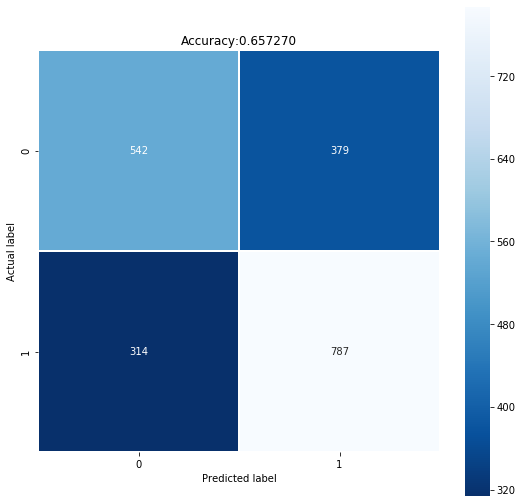

((muse,), total)     0.152511
((muse,), (G, A))    0.087793
((muse,), (C, T))    0.079402
((muse,), (C, A))    0.057070
((muse,), (G, T))    0.054364
((muse,), (C, G))    0.045768
((muse,), (T, C))    0.044608
((muse,), (G, C))    0.043583
((muse,), (A, G))    0.042998
((muse,), (T, A))    0.034950
((muse,), (A, T))    0.034223
((muse,), (T, G))    0.026195
((muse,), (A, C))    0.025944
cancer_BRCA          0.019431
cancer_THCA          0.017153
cancer_OV            0.013181
cancer_HNSC          0.012332
cancer_LGG           0.011992
cancer_UCEC          0.011869
cancer_LIHC          0.011582
cancer_KIRC          0.011124
cancer_LUAD          0.010939
cancer_GBM           0.010647
cancer_STAD          0.010609
cancer_CESC          0.010115
cancer_BLCA          0.009909
cancer_LUSC          0.008943
cancer_COAD          0.008860
cancer_KIRP          0.008589
cancer_SKCM          0.008374
cancer_PRAD          0.008265
cancer_PAAD          0.006928
cancer_SARC          0.006902
cancer_ESC

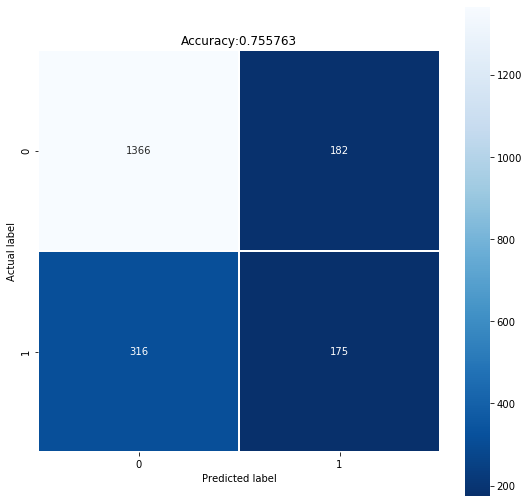

((muse,), total)     0.139428
((muse,), (C, T))    0.103270
((muse,), (G, A))    0.093271
((muse,), (C, A))    0.065957
((muse,), (G, T))    0.061382
((muse,), (T, C))    0.049132
((muse,), (G, C))    0.047663
((muse,), (A, G))    0.045681
((muse,), (C, G))    0.043302
((muse,), (T, A))    0.033890
((muse,), (A, T))    0.033372
((muse,), (A, C))    0.026751
((muse,), (T, G))    0.026370
cancer_OV            0.019482
cancer_BRCA          0.017104
cancer_UCEC          0.013761
cancer_HNSC          0.013436
cancer_LUAD          0.011686
cancer_LUSC          0.010224
cancer_LGG           0.009172
cancer_LIHC          0.009103
cancer_GBM           0.008983
cancer_SKCM          0.008825
cancer_COAD          0.008547
cancer_LAML          0.008541
cancer_BLCA          0.008284
cancer_STAD          0.007994
cancer_ESCA          0.007976
cancer_CESC          0.007199
cancer_KIRC          0.006707
cancer_PRAD          0.006525
cancer_THCA          0.005803
cancer_READ          0.005699
cancer_SAR

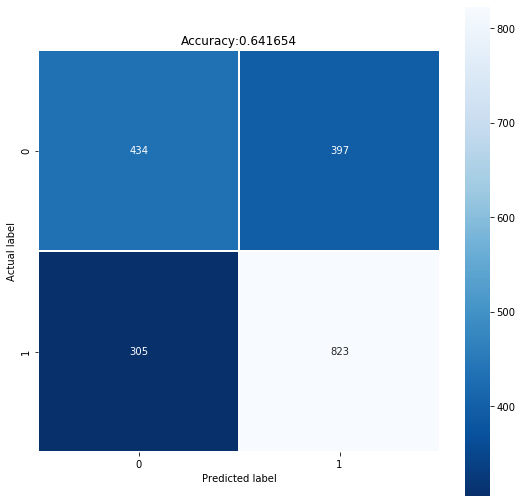

((muse,), total)     0.155850
((muse,), (G, A))    0.081124
((muse,), (C, T))    0.077671
((muse,), (G, T))    0.059340
((muse,), (C, A))    0.057521
((muse,), (C, G))    0.045208
((muse,), (T, C))    0.044121
((muse,), (G, C))    0.043094
((muse,), (A, G))    0.041704
((muse,), (A, T))    0.033214
((muse,), (T, A))    0.031370
((muse,), (A, C))    0.026944
((muse,), (T, G))    0.026288
cancer_BRCA          0.021224
cancer_THCA          0.018262
cancer_OV            0.013007
cancer_HNSC          0.012932
cancer_LGG           0.012442
cancer_LIHC          0.012014
cancer_UCEC          0.011739
cancer_GBM           0.011305
cancer_LUAD          0.010762
cancer_STAD          0.010596
cancer_KIRC          0.010485
cancer_SKCM          0.010125
cancer_CESC          0.010014
cancer_PRAD          0.009398
cancer_COAD          0.009148
cancer_KIRP          0.008877
cancer_LUSC          0.008556
cancer_BLCA          0.008296
cancer_ESCA          0.007089
cancer_SARC          0.007036
cancer_PAA

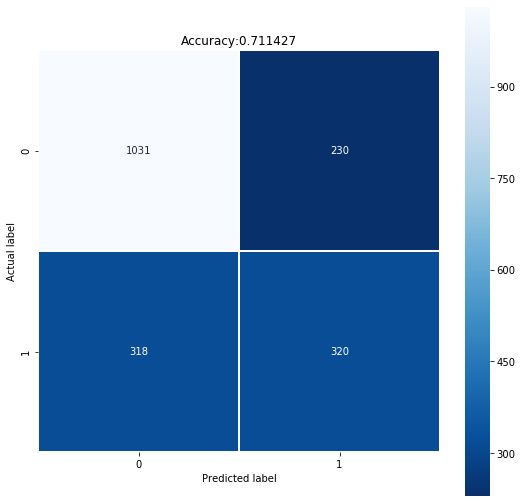

((mutect,), total)     0.160352
((mutect,), (C, T))    0.098390
((mutect,), (G, A))    0.098002
((mutect,), (C, A))    0.066003
((mutect,), (G, T))    0.057036
((mutect,), (G, C))    0.047055
((mutect,), (C, G))    0.045314
((mutect,), (A, G))    0.043574
((mutect,), (T, C))    0.043137
((mutect,), (A, T))    0.031024
((mutect,), (T, A))    0.029858
((mutect,), (A, C))    0.026996
((mutect,), (T, G))    0.025360
cancer_BRCA            0.019233
cancer_OV              0.014755
cancer_UCEC            0.014698
cancer_GBM             0.014023
cancer_HNSC            0.012060
cancer_LGG             0.010469
cancer_COAD            0.009958
cancer_LIHC            0.009443
cancer_BLCA            0.009215
cancer_LUAD            0.008596
cancer_STAD            0.008052
cancer_LUSC            0.007586
cancer_SKCM            0.007324
cancer_PAAD            0.007243
cancer_CESC            0.007214
cancer_KIRC            0.007207
cancer_PRAD            0.006877
cancer_ESCA            0.006767
cancer_T

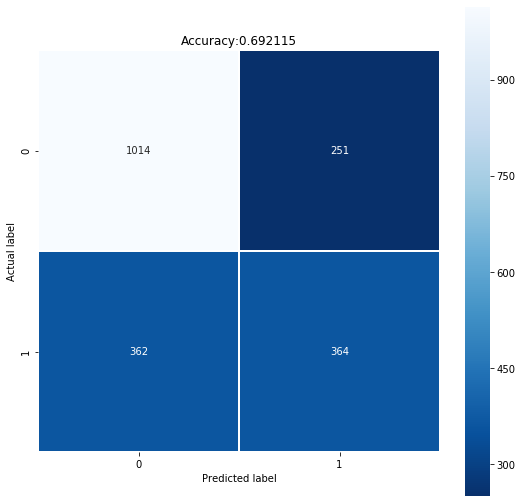

((mutect,), total)     0.159445
((mutect,), (C, T))    0.098013
((mutect,), (G, A))    0.092114
((mutect,), (G, T))    0.056904
((mutect,), (C, A))    0.056553
((mutect,), (A, G))    0.046553
((mutect,), (C, G))    0.046462
((mutect,), (T, C))    0.043596
((mutect,), (G, C))    0.043092
((mutect,), (T, A))    0.032695
((mutect,), (A, T))    0.032256
((mutect,), (A, C))    0.027382
((mutect,), (T, G))    0.024462
cancer_BRCA            0.017632
cancer_UCEC            0.015002
cancer_OV              0.014609
cancer_GBM             0.011714
cancer_HNSC            0.011606
cancer_COAD            0.011169
cancer_LGG             0.010329
cancer_THCA            0.009962
cancer_PRAD            0.009955
cancer_LUAD            0.009830
cancer_STAD            0.009098
cancer_KIRC            0.008548
cancer_LIHC            0.008277
cancer_LUSC            0.008252
cancer_BLCA            0.008245
cancer_SKCM            0.007263
cancer_ESCA            0.007200
cancer_LAML            0.006921
cancer_R

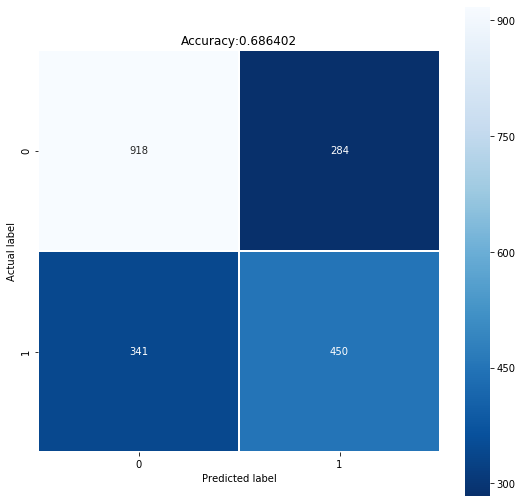

((mutect,), total)     0.159314
((mutect,), (C, T))    0.097002
((mutect,), (G, A))    0.093929
((mutect,), (C, A))    0.059567
((mutect,), (G, T))    0.056333
((mutect,), (C, G))    0.046300
((mutect,), (G, C))    0.044598
((mutect,), (T, C))    0.042737
((mutect,), (A, G))    0.041553
((mutect,), (A, T))    0.032848
((mutect,), (T, A))    0.032706
((mutect,), (T, G))    0.026849
((mutect,), (A, C))    0.026490
cancer_BRCA            0.019125
cancer_OV              0.015240
cancer_UCEC            0.014235
cancer_HNSC            0.011891
cancer_GBM             0.011582
cancer_LUAD            0.010445
cancer_LGG             0.010295
cancer_LIHC            0.010262
cancer_STAD            0.009389
cancer_COAD            0.008972
cancer_KIRC            0.008487
cancer_BLCA            0.008075
cancer_LUSC            0.007984
cancer_ESCA            0.007925
cancer_PRAD            0.007903
cancer_CESC            0.007878
cancer_SKCM            0.007517
cancer_THCA            0.007209
cancer_L

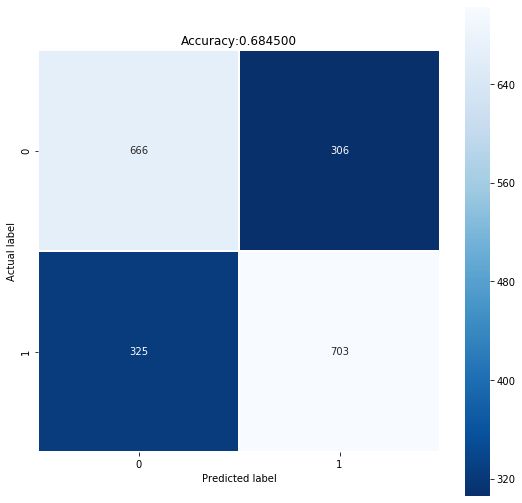

((somaticsniper,), total)     0.154848
((somaticsniper,), (G, A))    0.087475
((somaticsniper,), (C, T))    0.085237
((somaticsniper,), (C, A))    0.055686
((somaticsniper,), (G, T))    0.051333
((somaticsniper,), (C, G))    0.044399
((somaticsniper,), (T, C))    0.042086
((somaticsniper,), (G, C))    0.040025
((somaticsniper,), (A, G))    0.037684
((somaticsniper,), (A, T))    0.033080
((somaticsniper,), (T, A))    0.031460
((somaticsniper,), (A, C))    0.024663
((somaticsniper,), (T, G))    0.024110
cancer_THCA                   0.021417
cancer_LUSC                   0.020651
cancer_STAD                   0.014919
cancer_LUAD                   0.014793
cancer_BRCA                   0.013266
cancer_UCEC                   0.012369
cancer_LIHC                   0.011986
cancer_HNSC                   0.011864
cancer_OV                     0.011633
cancer_COAD                   0.011540
cancer_GBM                    0.010110
cancer_KIRC                   0.009880
cancer_BLCA              

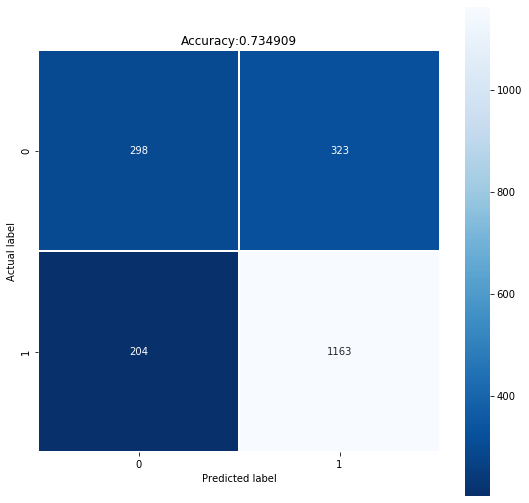

((somaticsniper,), total)     0.149302
((somaticsniper,), (G, A))    0.075122
((somaticsniper,), (C, T))    0.073791
((somaticsniper,), (C, A))    0.059482
((somaticsniper,), (G, T))    0.048181
((somaticsniper,), (G, C))    0.042865
cancer_THCA                   0.042245
((somaticsniper,), (C, G))    0.036777
((somaticsniper,), (A, G))    0.035152
((somaticsniper,), (T, C))    0.033077
((somaticsniper,), (A, T))    0.027587
((somaticsniper,), (T, A))    0.026745
cancer_BRCA                   0.023694
((somaticsniper,), (A, C))    0.022190
((somaticsniper,), (T, G))    0.019991
cancer_STAD                   0.016747
cancer_LUAD                   0.015282
cancer_LIHC                   0.014008
cancer_LGG                    0.013852
cancer_GBM                    0.013199
cancer_KIRC                   0.012372
cancer_PCPG                   0.011927
cancer_OV                     0.011902
cancer_HNSC                   0.011790
cancer_LUSC                   0.011730
cancer_COAD              

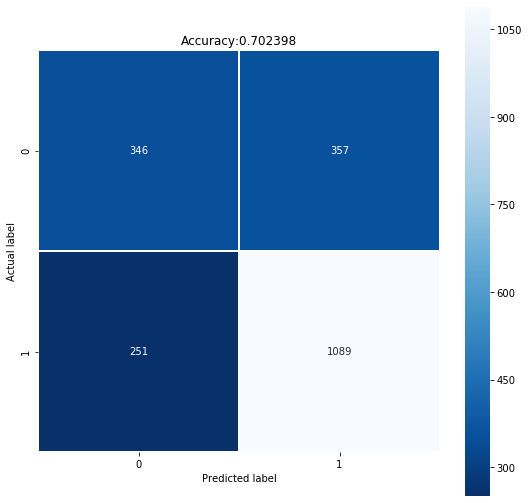

((somaticsniper,), total)     0.145159
((somaticsniper,), (C, T))    0.075572
((somaticsniper,), (G, A))    0.071078
((somaticsniper,), (C, A))    0.060523
((somaticsniper,), (G, T))    0.048021
((somaticsniper,), (G, C))    0.041554
((somaticsniper,), (C, G))    0.038691
((somaticsniper,), (A, G))    0.037348
((somaticsniper,), (T, C))    0.036038
cancer_THCA                   0.034032
((somaticsniper,), (A, T))    0.029274
((somaticsniper,), (T, A))    0.029248
((somaticsniper,), (A, C))    0.023641
((somaticsniper,), (T, G))    0.021683
cancer_BRCA                   0.021627
cancer_LIHC                   0.015436
cancer_LUSC                   0.014741
cancer_STAD                   0.014617
cancer_PCPG                   0.014311
cancer_KIRP                   0.013212
cancer_HNSC                   0.013011
cancer_LGG                    0.012996
cancer_GBM                    0.012706
cancer_OV                     0.012481
cancer_CESC                   0.012339
cancer_KIRC              

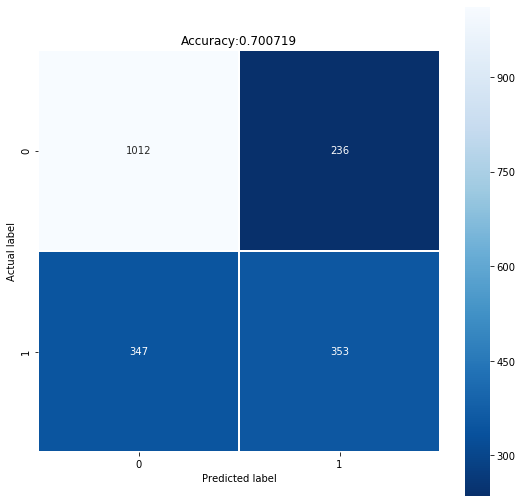

((varscan,), total)     0.164426
((varscan,), (C, T))    0.093303
((varscan,), (G, A))    0.087813
((varscan,), (C, A))    0.059365
((varscan,), (G, T))    0.058470
((varscan,), (C, G))    0.046618
((varscan,), (T, C))    0.046220
((varscan,), (A, G))    0.045627
((varscan,), (G, C))    0.044379
((varscan,), (A, T))    0.032387
((varscan,), (T, A))    0.032110
((varscan,), (A, C))    0.024997
((varscan,), (T, G))    0.024695
cancer_OV               0.020440
cancer_BRCA             0.016701
cancer_HNSC             0.013663
cancer_LGG              0.011495
cancer_STAD             0.011340
cancer_LUAD             0.010935
cancer_UCEC             0.010811
cancer_LUSC             0.010758
cancer_LIHC             0.010106
cancer_GBM              0.009898
cancer_COAD             0.009320
cancer_BLCA             0.009052
cancer_PAAD             0.008749
cancer_THCA             0.008341
cancer_KIRC             0.008207
cancer_SKCM             0.007542
cancer_PRAD             0.007027
cancer_KIR

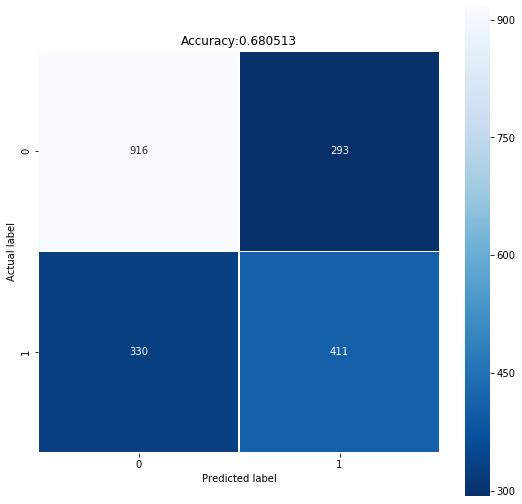

((varscan,), total)     0.161431
((varscan,), (C, T))    0.097152
((varscan,), (G, A))    0.084709
((varscan,), (C, A))    0.057166
((varscan,), (G, T))    0.055689
((varscan,), (C, G))    0.046567
((varscan,), (G, C))    0.046260
((varscan,), (A, G))    0.044364
((varscan,), (T, C))    0.043448
((varscan,), (T, A))    0.032655
((varscan,), (A, T))    0.032622
((varscan,), (T, G))    0.026692
((varscan,), (A, C))    0.025891
cancer_OV               0.019252
cancer_BRCA             0.015899
cancer_HNSC             0.012785
cancer_THCA             0.012159
cancer_UCEC             0.011603
cancer_GBM              0.011309
cancer_LUAD             0.011191
cancer_STAD             0.010990
cancer_LIHC             0.010968
cancer_LGG              0.010430
cancer_COAD             0.009793
cancer_PAAD             0.009416
cancer_LUSC             0.009255
cancer_BLCA             0.009129
cancer_PRAD             0.007678
cancer_CESC             0.007516
cancer_KIRC             0.007509
cancer_KIR

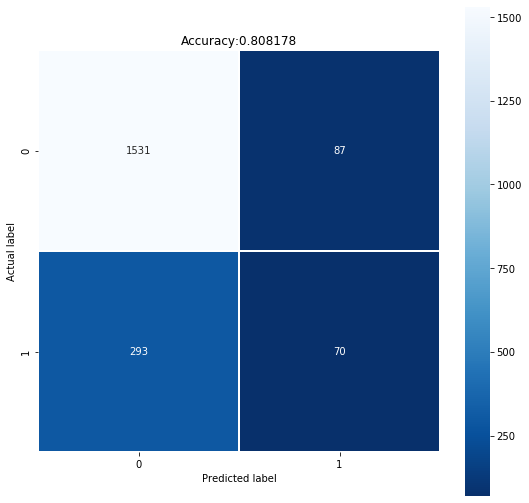

((varscan,), total)     0.133066
((varscan,), (C, T))    0.131782
((varscan,), (G, A))    0.103286
((varscan,), (C, A))    0.060684
((varscan,), (G, T))    0.056976
((varscan,), (T, C))    0.046798
((varscan,), (A, G))    0.046102
((varscan,), (G, C))    0.039688
((varscan,), (C, G))    0.034778
((varscan,), (A, T))    0.034140
((varscan,), (T, A))    0.033115
((varscan,), (T, G))    0.032003
((varscan,), (A, C))    0.028851
cancer_UCEC             0.018551
cancer_LGG              0.018364
cancer_OV               0.018119
cancer_SKCM             0.016535
cancer_BRCA             0.014193
cancer_HNSC             0.011693
cancer_BLCA             0.011181
cancer_COAD             0.009500
cancer_GBM              0.009252
cancer_UCS              0.008260
cancer_LUAD             0.008184
cancer_SARC             0.007702
cancer_ESCA             0.007042
cancer_LUSC             0.006871
cancer_STAD             0.006753
cancer_CESC             0.005885
cancer_LIHC             0.005174
cancer_PRA

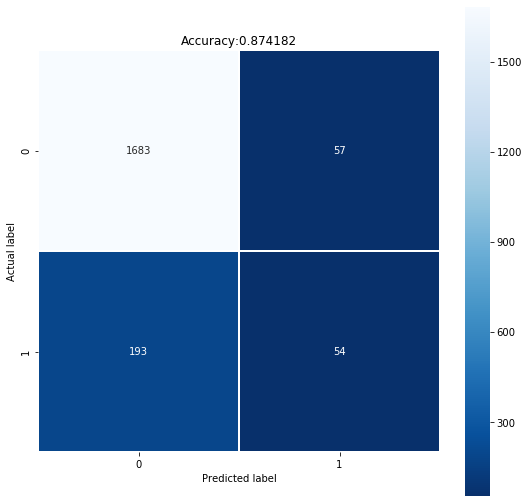

((mutect,), total)          0.087029
((muse, mutect), (C, T))    0.072129
((muse,), total)            0.064067
((muse, mutect), total)     0.058004
((muse, mutect), (G, A))    0.052219
((muse,), (G, A))           0.041821
((muse,), (C, T))           0.037911
((muse, mutect), (G, T))    0.036742
((muse, mutect), (A, G))    0.036406
((muse, mutect), (T, C))    0.032693
((muse, mutect), (T, A))    0.028787
((muse, mutect), (C, A))    0.028259
cancer_LAML                 0.025192
((mutect,), (C, T))         0.024003
((mutect,), (G, A))         0.023466
cancer_OV                   0.022729
((muse, mutect), (C, G))    0.020532
((muse, mutect), (G, C))    0.017847
((muse, mutect), (A, T))    0.017800
((mutect,), (G, T))         0.015079
((muse, mutect), (A, C))    0.013956
((mutect,), (C, A))         0.013476
((muse, mutect), (T, G))    0.012902
((mutect,), (A, T))         0.011186
((muse,), (C, A))           0.011184
((muse,), (G, T))           0.010466
((mutect,), (T, C))         0.010319
c

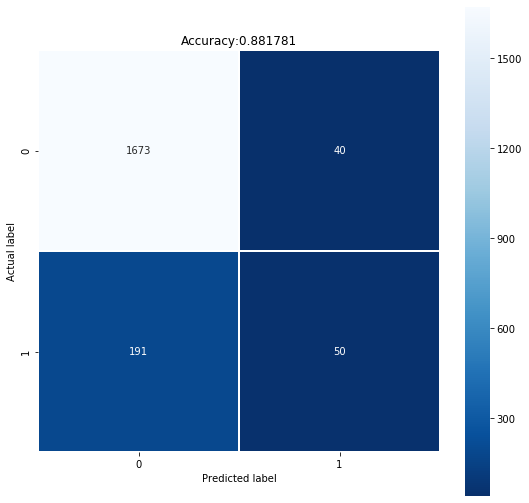

((mutect,), total)          0.089355
((muse,), total)            0.078560
((muse, mutect), total)     0.066670
((muse, mutect), (C, T))    0.061942
((muse, mutect), (G, A))    0.061130
((muse,), (C, T))           0.044158
((muse, mutect), (A, G))    0.038501
((muse, mutect), (T, C))    0.036026
((muse, mutect), (C, A))    0.032340
((muse,), (G, A))           0.030822
((muse, mutect), (G, T))    0.029380
((mutect,), (G, A))         0.028014
((muse, mutect), (C, G))    0.024482
cancer_LAML                 0.022991
((muse, mutect), (T, A))    0.021002
cancer_OV                   0.019851
((mutect,), (C, T))         0.019437
((muse, mutect), (G, C))    0.018766
((muse, mutect), (A, T))    0.016063
((muse, mutect), (T, G))    0.015731
((muse, mutect), (A, C))    0.014859
((mutect,), (C, A))         0.012523
((mutect,), (T, C))         0.011882
((mutect,), (G, T))         0.011572
cancer_UCEC                 0.008706
((muse,), (G, T))           0.008262
((muse,), (C, A))           0.007981
c

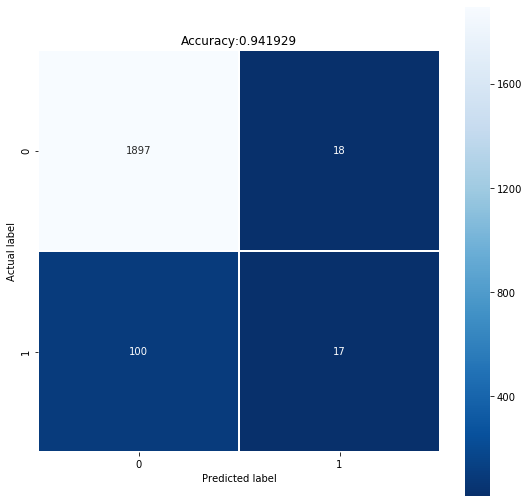

((muse,), total)             0.104569
((muse, varscan), total)     0.080391
((muse, varscan), (C, T))    0.078892
((varscan,), total)          0.078746
((muse, varscan), (G, A))    0.078157
((muse,), (G, A))            0.050539
((muse,), (C, T))            0.044103
((muse, varscan), (C, A))    0.035035
((muse, varscan), (A, T))    0.030668
((varscan,), (G, A))         0.028414
((varscan,), (C, T))         0.027065
((muse, varscan), (A, G))    0.026936
((muse, varscan), (A, C))    0.026575
((muse, varscan), (G, C))    0.024998
((muse, varscan), (T, C))    0.020338
((muse, varscan), (T, G))    0.018678
((muse, varscan), (G, T))    0.017085
((muse, varscan), (C, G))    0.014911
((muse, varscan), (T, A))    0.014061
cancer_LGG                   0.012799
cancer_SARC                  0.012665
cancer_SKCM                  0.010583
((varscan,), (G, T))         0.007968
cancer_UCS                   0.006549
((muse,), (G, T))            0.006506
((muse,), (A, G))            0.006433
((muse,), (C

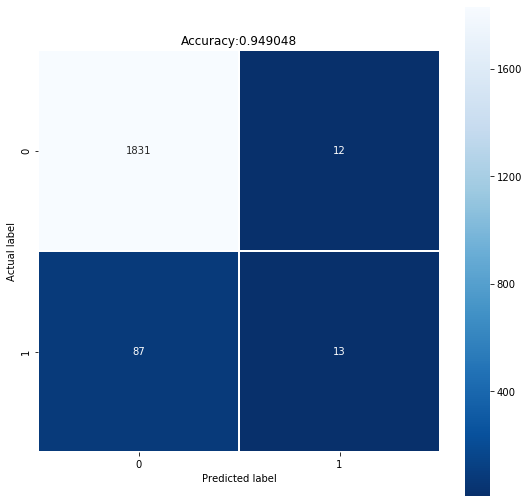

((muse, varscan), total)     0.082700
((muse, varscan), (G, A))    0.079880
((varscan,), total)          0.076371
((muse, varscan), (C, T))    0.072533
((muse,), total)             0.068774
((muse, varscan), (C, A))    0.049128
((muse,), (C, T))            0.048169
((varscan,), (G, A))         0.046753
((varscan,), (C, T))         0.041015
((muse,), (G, A))            0.034766
((muse, varscan), (T, C))    0.032423
((muse, varscan), (C, G))    0.025297
((muse, varscan), (A, C))    0.024536
((muse, varscan), (T, G))    0.021125
((muse, varscan), (G, T))    0.018820
((muse, varscan), (A, G))    0.017005
((muse, varscan), (G, C))    0.016605
((muse, varscan), (A, T))    0.016392
cancer_SARC                  0.015545
((muse, varscan), (T, A))    0.014359
cancer_LGG                   0.013710
cancer_UCEC                  0.011875
cancer_UCS                   0.011751
cancer_BLCA                  0.010203
((muse,), (A, G))            0.009040
cancer_SKCM                  0.008358
((varscan,),

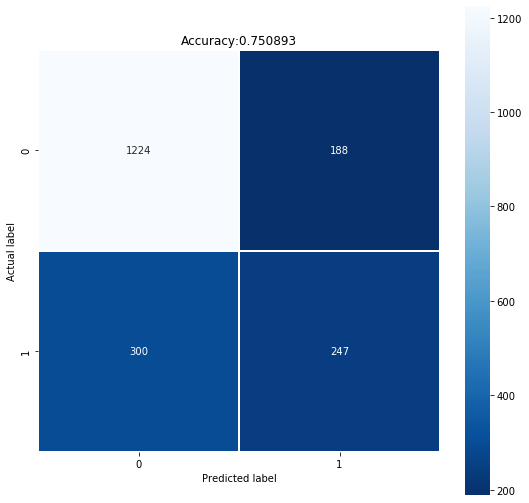

((varscan,), total)                   0.115811
((somaticsniper,), total)             0.065753
((somaticsniper, varscan), (C, T))    0.057181
((somaticsniper, varscan), total)     0.054920
((somaticsniper, varscan), (G, A))    0.052148
((varscan,), (C, T))                  0.048591
((varscan,), (G, A))                  0.037056
((somaticsniper, varscan), (C, A))    0.032915
((somaticsniper, varscan), (G, T))    0.032128
((somaticsniper, varscan), (T, C))    0.027730
((somaticsniper, varscan), (C, G))    0.024446
((somaticsniper, varscan), (G, C))    0.024398
((somaticsniper, varscan), (A, G))    0.024125
((varscan,), (G, C))                  0.020869
((varscan,), (C, A))                  0.020266
((somaticsniper, varscan), (T, A))    0.019770
cancer_OV                             0.018517
((somaticsniper, varscan), (A, T))    0.017901
((varscan,), (G, T))                  0.017042
((varscan,), (C, G))                  0.014081
((somaticsniper, varscan), (T, G))    0.013966
cancer_BRCA  

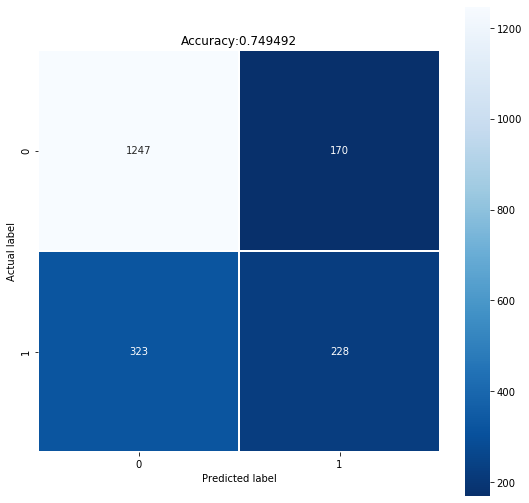

((varscan,), total)                   0.119268
((somaticsniper, varscan), total)     0.067700
((somaticsniper,), total)             0.065987
((somaticsniper, varscan), (C, T))    0.051294
((somaticsniper, varscan), (G, A))    0.047516
((varscan,), (C, T))                  0.040918
((varscan,), (G, A))                  0.038513
((somaticsniper, varscan), (G, T))    0.034857
((somaticsniper, varscan), (C, A))    0.031344
((somaticsniper, varscan), (T, C))    0.028231
((somaticsniper, varscan), (C, G))    0.026575
((somaticsniper, varscan), (A, G))    0.024511
((varscan,), (C, A))                  0.022777
((somaticsniper, varscan), (G, C))    0.022583
((varscan,), (G, T))                  0.021642
((varscan,), (G, C))                  0.018265
cancer_OV                             0.017889
((somaticsniper, varscan), (T, A))    0.017294
((somaticsniper, varscan), (A, T))    0.016934
cancer_BRCA                           0.015198
((varscan,), (C, G))                  0.013845
((somaticsnip

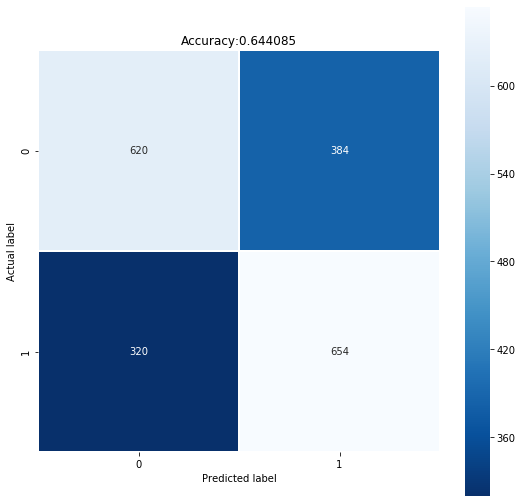

((muse,), total)                   0.089231
((somaticsniper,), total)          0.066609
((somaticsniper, muse), total)     0.059605
((somaticsniper, muse), (G, A))    0.045782
((somaticsniper, muse), (C, T))    0.045684
((somaticsniper, muse), (C, A))    0.034088
((somaticsniper, muse), (G, T))    0.029990
((muse,), (C, T))                  0.026938
((somaticsniper, muse), (A, G))    0.026815
((muse,), (G, A))                  0.025839
((somaticsniper, muse), (T, C))    0.025623
((somaticsniper, muse), (C, G))    0.025219
((somaticsniper, muse), (G, C))    0.025218
((somaticsniper, muse), (A, T))    0.019956
((somaticsniper, muse), (T, A))    0.019369
cancer_THCA                        0.018180
cancer_BRCA                        0.017931
((somaticsniper, muse), (T, G))    0.015752
((somaticsniper, muse), (A, C))    0.015685
((muse,), (C, A))                  0.015456
((muse,), (G, T))                  0.015392
((muse,), (C, G))                  0.014280
((muse,), (G, C))               

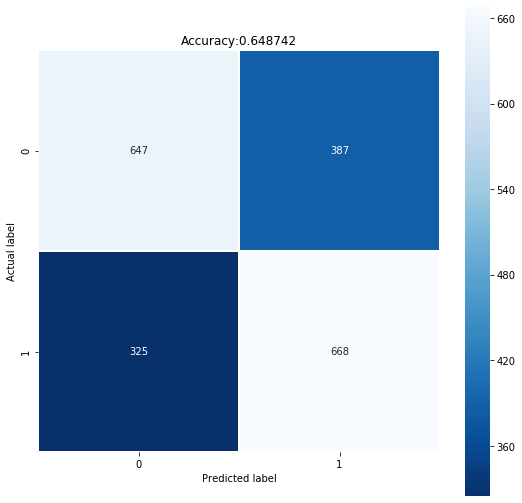

((muse,), total)                   0.082249
((somaticsniper,), total)          0.068082
((somaticsniper, muse), total)     0.057355
((somaticsniper, muse), (G, A))    0.046472
((somaticsniper, muse), (C, T))    0.045480
((somaticsniper, muse), (C, A))    0.033075
((somaticsniper, muse), (G, T))    0.030725
((muse,), (G, A))                  0.028669
((muse,), (C, T))                  0.026524
((somaticsniper, muse), (T, C))    0.025840
((somaticsniper, muse), (A, G))    0.025560
((somaticsniper, muse), (C, G))    0.024740
((somaticsniper, muse), (G, C))    0.024374
((somaticsniper, muse), (A, T))    0.020651
cancer_BRCA                        0.019829
((somaticsniper, muse), (T, A))    0.019318
((muse,), (C, A))                  0.016946
cancer_THCA                        0.016821
((somaticsniper, muse), (A, C))    0.016580
((muse,), (G, T))                  0.016137
((somaticsniper, muse), (T, G))    0.015693
((muse,), (G, C))                  0.014325
((muse,), (C, G))               

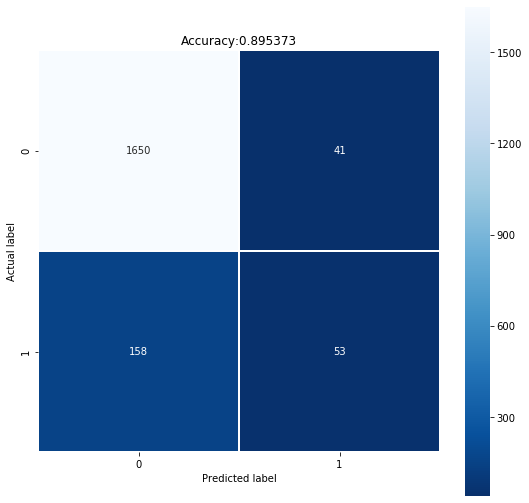

((somaticsniper,), total)            0.083014
((mutect,), total)                   0.082969
((somaticsniper, mutect), total)     0.075684
((somaticsniper, mutect), (G, A))    0.066315
((mutect,), (C, T))                  0.062061
((somaticsniper, mutect), (C, T))    0.059904
((mutect,), (G, A))                  0.039093
((somaticsniper,), (C, T))           0.035507
((somaticsniper, mutect), (A, G))    0.030975
((mutect,), (G, T))                  0.030037
((somaticsniper, mutect), (G, T))    0.028521
((somaticsniper, mutect), (C, A))    0.028186
((somaticsniper,), (G, A))           0.025073
((mutect,), (C, A))                  0.023651
((somaticsniper, mutect), (T, C))    0.020908
((somaticsniper, mutect), (C, G))    0.020158
((somaticsniper, mutect), (G, C))    0.017127
((somaticsniper, mutect), (A, T))    0.016996
((mutect,), (T, C))                  0.016651
((somaticsniper, mutect), (T, A))    0.014762
((mutect,), (C, G))                  0.014390
((mutect,), (G, C))               

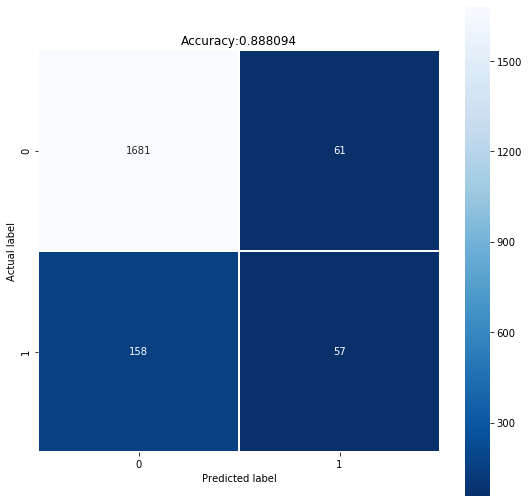

((mutect,), total)                   0.117186
((somaticsniper, mutect), total)     0.086094
((mutect,), (C, T))                  0.062800
((somaticsniper, mutect), (G, A))    0.060655
((somaticsniper,), total)            0.054093
((somaticsniper, mutect), (C, T))    0.047935
((somaticsniper, mutect), (C, A))    0.046822
((mutect,), (G, T))                  0.041564
((mutect,), (G, A))                  0.040268
((somaticsniper, mutect), (T, C))    0.029301
((somaticsniper, mutect), (G, T))    0.027239
((somaticsniper,), (C, T))           0.025542
((mutect,), (C, A))                  0.022495
((somaticsniper,), (G, A))           0.021655
((somaticsniper, mutect), (A, G))    0.021421
((somaticsniper, mutect), (C, G))    0.019411
((somaticsniper, mutect), (G, C))    0.017484
((mutect,), (T, C))                  0.015266
((somaticsniper, mutect), (T, A))    0.014521
((somaticsniper, mutect), (A, T))    0.012585
((mutect,), (C, G))                  0.012276
((mutect,), (G, C))               

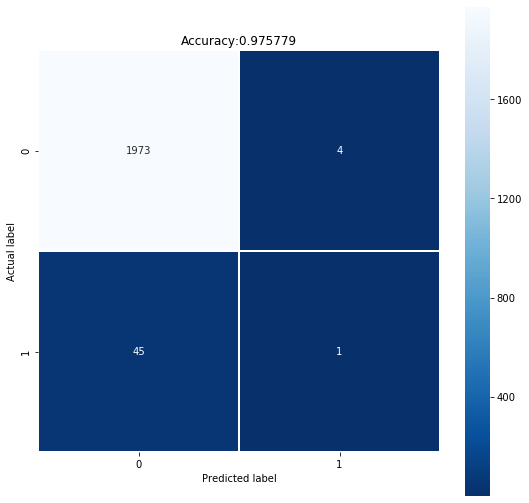

((varscan,), (C, T))           0.157626
((varscan,), (G, A))           0.109915
((varscan,), total)            0.077989
((varscan, mutect), (G, A))    0.062237
((varscan, mutect), (A, G))    0.045076
((varscan, mutect), (C, T))    0.039689
((varscan, mutect), (G, T))    0.038879
((mutect,), total)             0.036303
((varscan, mutect), total)     0.036266
((mutect,), (C, T))            0.030688
((varscan,), (T, C))           0.030603
((varscan, mutect), (T, C))    0.023184
((mutect,), (G, A))            0.019570
cancer_GBM                     0.017762
((varscan,), (A, G))           0.015739
((varscan,), (C, A))           0.015224
((varscan, mutect), (C, A))    0.014259
((varscan, mutect), (A, C))    0.013564
((varscan, mutect), (T, A))    0.013313
((varscan, mutect), (T, G))    0.012919
((varscan,), (G, T))           0.012842
cancer_UCEC                    0.012042
((varscan, mutect), (G, C))    0.010439
((varscan, mutect), (C, G))    0.010023
((varscan, mutect), (A, T))    0.009614


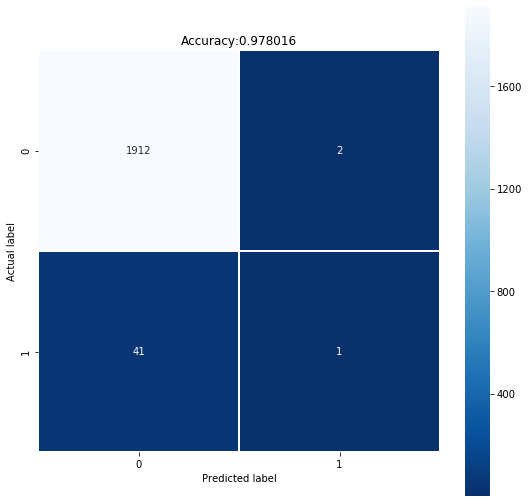

((varscan,), (C, T))           0.159971
((varscan,), (G, A))           0.079927
((varscan, mutect), (G, T))    0.053050
((varscan, mutect), (A, G))    0.052196
((varscan, mutect), (G, A))    0.047910
((varscan,), total)            0.047172
((varscan, mutect), total)     0.044080
((mutect,), total)             0.041913
((varscan, mutect), (C, T))    0.041212
((varscan,), (T, C))           0.037192
cancer_GBM                     0.036858
((varscan, mutect), (T, A))    0.027716
((varscan, mutect), (G, C))    0.027148
((varscan,), (G, T))           0.019811
((varscan, mutect), (T, C))    0.019772
((mutect,), (C, T))            0.017921
((mutect,), (G, A))            0.015377
((varscan, mutect), (A, C))    0.013899
((mutect,), (T, C))            0.013030
((varscan, mutect), (A, T))    0.012214
((varscan, mutect), (C, A))    0.011904
((varscan,), (C, A))           0.010557
cancer_UCEC                    0.010190
cancer_UCS                     0.009176
((mutect,), (G, T))            0.008932


In [41]:
stats_table = pd.DataFrame(0, index = index, columns = ['average accuracy', 'average precision', 'average recall', 'average lower left quad', 'average lower right quad'])
sampling_strat = [1,0.75,1,0.7,0.18,0.0875,0.5,1,0.16,0.055]
#sampling_strat = [0,0,0,0,0,0,0,0,0,0]
ind = 0

for c in possible_callers:
    acc = []
    pre = []
    rec = []
    pzan = []
    pnan = []
    for caller in possible_callers:
        if caller != c:
            accuracy, label_pred, data_test, meta, add_caller_index, p, r, data_train = algo([c], [caller], sampling_strat[ind],0) #sampling_strat[ind]
            p1 = predicted_zero_actual_notzero(data_test, meta, add_caller_index)
            p2 = predicted_notzero_actual_notzero(data_test, meta, add_caller_index)
            acc.append(accuracy)
            pre.append(p)
            rec.append(r)
            pzan.append(p1)
            pnan.append(p2)
    ind += 1
    stats_table.loc[c] = [np.mean(acc), np.mean(pre), np.mean(rec), np.mean(pzan), np.mean(pnan)]
    
for i in range(4,len(index)):
    acc = []
    pre = []
    rec = []
    pzan = []
    pnan = []
    for c in possible_callers:
        if c not in index[i]:
            accuracy, label_pred, data_test, meta, add_caller_index, p, r = algo(index[i], [c], sampling_strat[ind],0)
            p1 = predicted_zero_actual_notzero(data_test, meta, add_caller_index)
            p2 = predicted_notzero_actual_notzero(data_test, meta, add_caller_index)
            acc.append(accuracy)
            pre.append(p)
            rec.append(r)
            pzan.append(p1)
            if np.isnan(p2) == False:              
                pnan.append(p2)
    ind += 1
    #print(pnan)
    stats_table.iloc[i] = [np.mean(acc), np.mean(pre), np.mean(rec), np.mean(pzan), np.mean(pnan)]
            
print(stats_table)  



In [5]:
def predicted_zero_actual_notzero(data_test, meta, add_caller_index):
    add_caller_1 = {i:0 for i in range(len(data_test))}
    count = []
    for i in range(len(data_test)):
        add_caller_1[i] = data_test.iloc[i][list(meta.columns)[add_caller_index[0]]] - data_test.iloc[i][list(meta.columns)[1]]
        if label_pred[i] == 0:
            if add_caller_1[i] != 0:
                count.append(add_caller_1[i])
    count = np.array(count)
    
    print(len(count))
    print("fraction of ones:", len([j for j in count if j == 1])/len(count))
    print("mean:", np.mean(count))
    print("std:", np.std(count))
    print("68% confidence interval:")
    print(np.mean(count) - 1*np.std(count), np.mean(count) + 1*np.std(count))
    return np.mean(count)

predicted_zero_actual_notzero(data_test, meta, add_caller_index)

180
fraction of ones: 0.8777777777777778
mean: 1.1722222222222223
std: 0.5852877312869814
68% confidence interval:
0.5869344909352409 1.7575099535092038


1.1722222222222223

In [7]:
def predicted_notzero_actual_notzero(data_test, meta, add_caller_index):
    add_1 = {i:0 for i in range(len(data_test))}
    percentages = []
    counts = []
    for i in range(len(data_test)):
        add_1[i] = data_test.iloc[i][list(meta.columns)[add_caller_index[0]]] - data_test.iloc[i][list(meta.columns)[1]]
        if label_pred[i] == 1:
            if add_1[i] != 0:
                counts.append(add_1[i])
    if len(counts) != 0:
        counts = np.array(counts)
        print(len(counts))
        print("fraction of ones:", len([j for j in counts if j == 1])/len(counts))
        print("mean:", np.mean(counts))
        print("std:", np.std(counts))
        print("68% confidence interval:")
        print(np.mean(counts) - 1*np.std(counts), np.mean(counts) + 1*np.std(counts))
        return np.mean(counts)
    else:
        return 0
predicted_notzero_actual_notzero(data_test, meta, add_caller_index)

44
fraction of ones: 0.4318181818181818
mean: 3.840909090909091
std: 7.449658875101054
68% confidence interval:
-3.6087497841919634 11.290567966010144


3.840909090909091

In [ ]:
caller_combs = ['mutect_varscan', 'mutect_muse', 'muse_somaticsniper', 'somaticsniper_mutect', 'muse_varcan', 'somaticsniper_varscan']
mutect_varscan = pd.read_pickle("./all_meta_varscan_mutect.pkl", compression='bz2')
mutect_varscan_count = np.array(mutect_varscan[list(mutect_varscan.columns)[1]])

mutect_muse = pd.read_pickle("./all_meta_mutect_muse.pkl", compression='bz2')
mutect_muse_count = np.array(mutect_muse[list(mutect_muse.columns)[1]])

muse_somaticsniper = pd.read_pickle("./all_meta_muse_somaticsniper.pkl", compression='bz2')
muse_somaticsniper_count = np.array(muse_somaticsniper[list(muse_somaticsniper.columns)[1]])

somaticsniper_mutect = pd.read_pickle("./all_meta_mutect_somaticsniper.pkl", compression='bz2')
somaticsniper_mutect_count = np.array(somaticsniper_mutect[list(somaticsniper_mutect.columns)[1]])

muse_varscan = pd.read_pickle("./all_meta_muse_varscan.pkl", compression='bz2')
muse_varscan_count = np.array(muse_varscan[list(muse_varscan.columns)[1]])

somaticsniper_varscan = pd.read_pickle("./all_meta_varscan_somaticsniper.pkl", compression='bz2')
somaticsniper_varscan_count = np.array(somaticsniper_varscan[list(somaticsniper_varscan.columns)[1]])

counts = {i:0 for i in caller_combs}
for i in range(len(mutect_varscan)):
    compare = [mutect_varscan_count[i], mutect_muse_count[i],muse_somaticsniper_count[i], somaticsniper_mutect_count[i],muse_varscan_count[i], somaticsniper_varscan_count[i]]
    max_index = np.argmax(compare)
    counts[caller_combs[max_index]] += 1



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:62: RuntimeWarning: divide by zero encountered in true_divide
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in true_divide
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:101: RuntimeWarning: divide by zero encountered in true_divide
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:101: RuntimeWarning: invalid value encountered in true_divide
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:101: RuntimeWarning: divide by zero encountered in true_divide
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:101: RuntimeWarning: invalid value encountered in true_divide
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:62: RuntimeWarning: divide by zero encountered in true_divide
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in true_divide
/anaconda3/lib/p

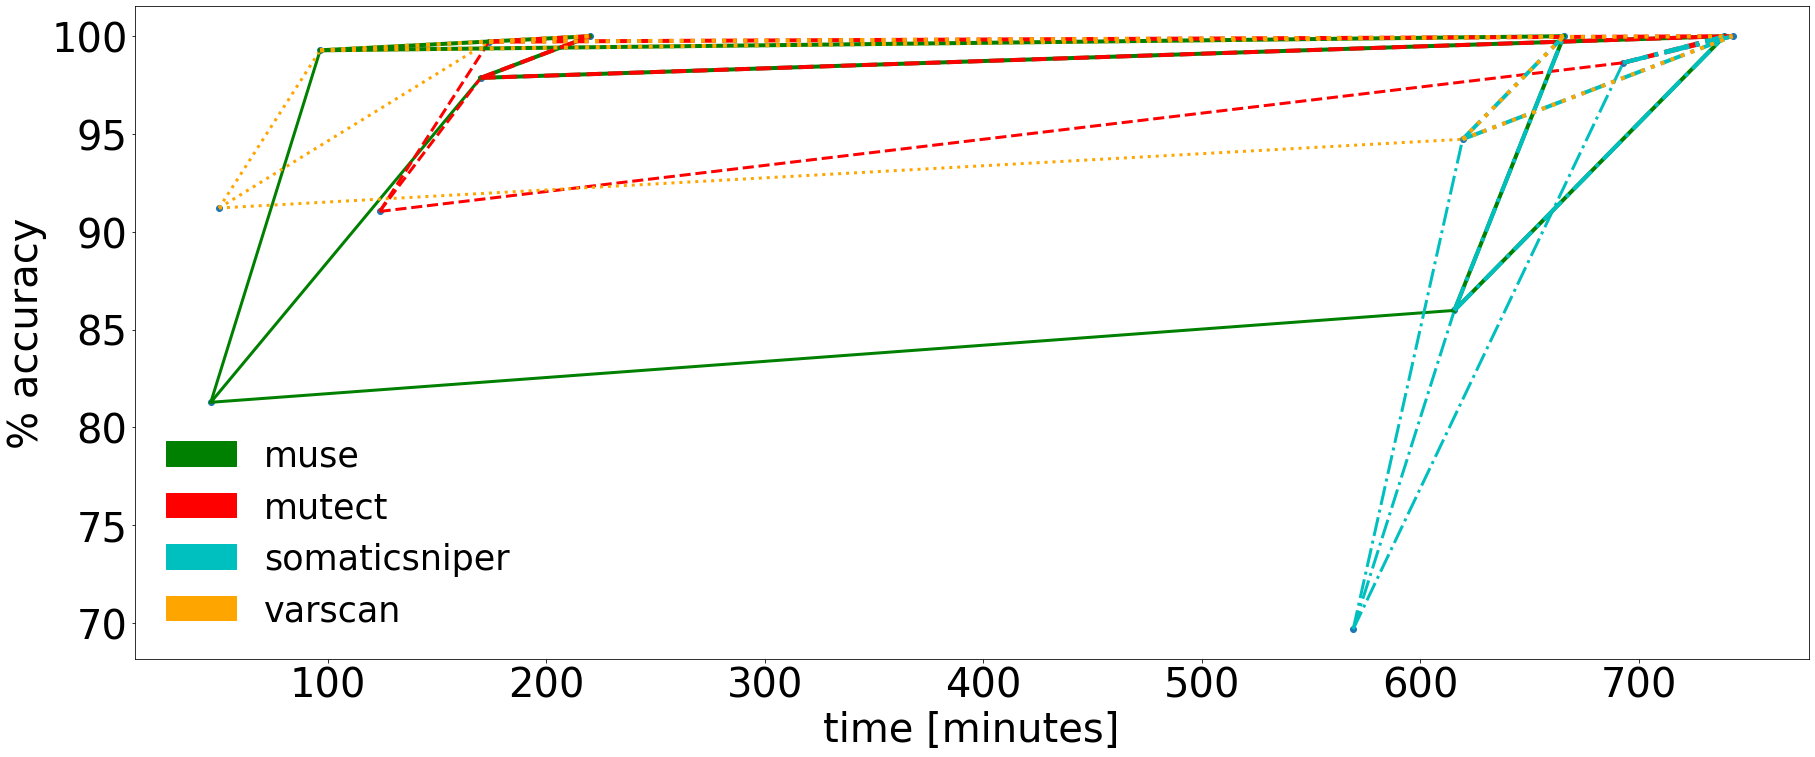

In [85]:
import matplotlib
from comb import my_combs
import matplotlib.patches as mpatches
"""
Muse: [ 0.59709659 34.37172798]
Mutect2: [ 3.68667135 49.88193294]
SomaticSniper: [26.0290123  48.77756772]
Varscan: [ 0.61099238 37.85508276]
"""

def muse(size):
    cost = size*0.59709659 + 34.37172798
    return cost

def mutect(size):
    cost = size*3.68667135 + 49.88193294
    return cost

def somaticsniper(size):
    cost = size*26.0290123 + 48.77756772
    return cost

def varscan(size):
    cost = size*0.61099238 + 37.85508276
    return cost



# store costs in a dicctionary for input size

possible_callers = ['muse', 'mutect', 'somaticsniper', 'varscan']
#plot + table with confidence intervals
def cost_accuracy(size):
    pkl_files = {}
    for file in os.listdir(os.getcwd()):
        if file.startswith("all_meta_"):
            callers = file.split(".pkl")[0].split("_")
            if len(callers) == 3:
                pkl_files[tuple([callers[2]])] = file
            if len(callers) == 4:
                pkl_files[tuple([callers[2],callers[3]])] = file
    
    data_cost = {}
    data_accuracy = {}
    cost = []
    accuracy = []
    for c in pkl_files:
        if len(c) == 1:
            #cost = []
            #accuracy = []
            meta = pd.read_pickle(pkl_files[c], compression='bz2')
            co = 0
            if 'mutect' in c:
                co += mutect(size)
            if 'muse' in c:
                co += muse(size)
            if 'varscan' in c:
                co += varscan(size)
            if 'somaticsniper' in c:
                co += somaticsniper(size)
            cost.append(co)
            percentages = 100*np.array(meta[list(meta.columns)[1]]) / np.array(meta[list(meta.columns)[5]])
            percentages = percentages[~np.isnan(percentages)]
            accuracy.append(np.average(percentages))
            """
            for caller in possible_callers:
                if caller != c[0]:
                    co = 0
                    if 'mutect' in c or caller == 'mutect':
                        co += mutect(size)
                    if 'muse' in c or caller == 'muse':
                        co += muse(size)
                    if 'varscan' in c or caller == 'varscan':
                        co += varscan(size)
                    if 'somaticsniper' in c or caller == 'somaticsniper':
                        co += somaticsniper(size)
                        
                    cost.append(co)
                    acc, label_pred, data_test, met, add_caller_index = algo([c[0]], [caller])    
                    not_zero_index = [i for i in range(len(label_pred)) if label_pred[i] != 0]
                    top = np.array(data_test[list(data_test.columns)[add_caller_index[0]]])
                    top = np.take(top, not_zero_index)
                    bottom = np.array(data_test[list(data_test.columns)[5]])
                    bottom = np.take(bottom, not_zero_index)
                    ave = top/bottom
                    ave = ave[~np.isnan(ave)]
                    accuracy.append(np.mean(ave))
              """ 
        if len(c) == 2:
            meta = pd.read_pickle(pkl_files[c], compression='bz2')
            co = 0
            if 'mutect' in c:
                co += mutect(size)
            if 'muse' in c:
                co += muse(size)
            if 'varscan' in c:
                co += varscan(size)
            if 'somaticsniper' in c:
                co += somaticsniper(size)
            cost.append(co)
            percentages = 100*np.array(meta[list(meta.columns)[1]]) / np.array(meta[list(meta.columns)[2]])
            percentages = percentages[~np.isnan(percentages)]
            accuracy.append(np.average(percentages))
            """
            for third in pkl_files:
                if len(third) == 2 and c[0] not in third:
                    co = 0
                    if 'mutect' in c or third[0] == 'mutect' or third[1] == 'mutect':
                        co += mutect(size)
                    if 'muse' in c or third[0] == 'muse' or third[1] == 'muse':
                        co += muse(size)
                    if 'varscan' in c or third[0] == 'varscan' or third[1] == 'varscan':
                        co += varscan(size)
                    if 'somaticsniper' in c or third[0] == 'somaticsniper' or third[1] == 'somaticsniper':
                        co += somaticsniper(size)                        
                    cost.append(co)
                    accuracy.append(1)
            """
    
        #data_cost[c] = cost
        #data_accuracy[c] = accuracy
    three_combs = my_combs(possible_callers, 3)
    for i in three_combs:
        co = 0
        if 'mutect' in i:
            co += mutect(size)
        if 'muse' in i:
            co += muse(size)
        if 'varscan' in i:
            co += varscan(size)
        if 'somaticsniper' in i:
            co += somaticsniper(size)
        cost.append(co)
        accuracy.append(100)
        
    plt.rcParams.update({'font.size': 15})
    
    matplotlib.rc('xtick', labelsize=40) 
    matplotlib.rc('ytick', labelsize=40) 
    plt.figure(figsize=(30,12))
    
    txt = []
    for c in pkl_files:
        txt.append(c)
    for i in three_combs:
        txt.append(i)

    
    plt.scatter(cost, accuracy)

    colors = ['g','r','c','orange']
    alpha = [1,1,1,1]
    ls = ['solid','dashed', 'dashdot', 'dotted']
    for k in range(len(possible_callers)):
        for i in range(len(cost)):
            if possible_callers[k] in txt[i] and len(txt[i]) == 1:
                for j in range(len(cost)):
                    if possible_callers[k] in txt[j] and len(txt[j]) == 2:
                        caller_x = (cost[i], cost[j])
                        caller_y = (accuracy[i], accuracy[j])
                        plt.plot(caller_x,caller_y, color = colors[k], linestyle = ls[k], alpha = alpha[k],linewidth=3)#,head_width=1, head_length = 100,length_includes_head=True)
    
    for k in range(len(possible_callers)):
        for i in range(len(cost)):
            if possible_callers[k] in txt[i] and len(txt[i]) == 2:
                for j in range(len(cost)):
                    if txt[i][0] in txt[j] and txt[i][1] in txt[j] and len(txt[j]) == 3:
                        caller_x = (cost[i], cost[j])
                        caller_y = (accuracy[i], accuracy[j])
                        plt.plot(caller_x, caller_y,color = colors[k], linestyle = ls[k], alpha = alpha[k],linewidth=4)
    
    plt.xlabel("time [minutes]", fontsize = 40)
    plt.ylabel("% accuracy",fontsize = 40)
    
    m = {'muse':1, 'mutect':2, 'somaticsniper':3, 'varscan':4}
    for j in range(len(txt)):
        save = txt[j]
        txt[j] = [m[x] for x in save]
    #for i in range(len(cost)):
    #    plt.annotate(txt[i], (cost[i], accuracy[i]))
    
    green_patch = mpatches.Patch(color='g', label='muse')
    red_patch = mpatches.Patch(color='r', label='mutect')
    blue_patch = mpatches.Patch(color='c', label='somaticsniper')
    cyan_patch = mpatches.Patch(color='orange', label='varscan')
    plt.legend(handles=[green_patch, red_patch, blue_patch, cyan_patch], fontsize = 35,frameon=False)

    plt.show()
    
    
cost_accuracy(20)    

In [191]:
meta_example = pd.read_pickle("all_meta_muse.pkl", compression='bz2')
rand_split = np.random.rand(len(meta_example))
train_list = rand_split < 0.8
test_list = rand_split >= 0.8

In [209]:


def algo_plot(caller, add_caller):
    if len(caller) == 1:
        meta = pd.read_pickle("all_meta_{}.pkl".format(caller[0]), compression='bz2')
        
    elif len(caller) == 2 and os.path.exists("all_meta_{}_{}.pkl".format(caller[0], caller[1])):
        meta = pd.read_pickle("all_meta_{}_{}.pkl".format(caller[0], caller[1]), compression='bz2')
        
    elif len(caller) == 2 and os.path.exists("all_meta_{}_{}.pkl".format(caller[1], caller[0])):
        meta = pd.read_pickle("all_meta_{}_{}.pkl".format(caller[1], caller[0]), compression='bz2')
        
    meta['label'] = np.zeros(len(meta.index))

    add_caller_index = [i for i in range(len(meta.columns)) if len(list(meta.columns)[i]) == (len(caller)+len(add_caller)) and  list(meta.columns)[i][len(caller)] == add_caller[0]]
    
    #print(meta, add_caller_index)
    
    label = np.array(meta[list(meta.columns)[add_caller_index[0]]]) - np.array(meta[list(meta.columns)[1]])
    label = (label > 0).astype(int)
    meta['label'] = label
    
    #print(meta)
    """
    rand_split = np.random.rand(len(meta))
    train_list = rand_split < 0.8
    test_list = rand_split >= 0.8
    """
    data_train = meta[train_list]
    data_test = meta[test_list]
    
    #print(data_test.index)
    
    train_labels = np.array(data_train['label'], dtype='f')
    test_labels = np.array(data_test['label'], dtype='f')
    
    drop = [i for i in meta.columns if i[0] == caller[0]]
    drop.append('label')

    train_features = np.array(data_train.drop(columns = drop), dtype='f')
    test_features = np.array(data_test.drop(columns = drop), dtype='f')
    
    meta_data = np.concatenate([train_features, test_features])
    meta_target = np.concatenate([train_labels, test_labels])  
    
    #Create a Gaussian Classifier
    clf=RandomForestClassifier(n_estimators=100)

    #Train the model using the training sets y_pred=clf.predict(X_test)
    clf.fit(train_features,train_labels)
    
    
    label_pred=clf.predict(test_features)
    
    accuracy = metrics.accuracy_score(test_labels, label_pred)
    cm = metrics.confusion_matrix(test_labels, label_pred)
    
    """
    plt.figure(figsize=(9,9))
    sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r')
    plt.ylabel('Actual label')
    plt.yticks((0.5,1.5),('zero', 'not zero'))
    plt.xticks((0.5,1.5),('zero', 'not zero'))
    plt.xlabel('Predicted label')
    plt.title("Accuracy:%f" % accuracy)
    plt.show()
    """
    index = meta.drop(columns = drop)
    feature_imp = pd.Series(clf.feature_importances_,index=index.columns).sort_values(ascending=False)
    
    #print(feature_imp)
    
    scores = cross_val_score(clf, meta_data, meta_target, cv=5)
    #print("Cross Validation Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
    drop = [i for i in range(len(meta.columns)) if list(meta.columns)[i][0] == caller[0]]
    drop.append(0)
    return accuracy, label_pred, data_test, meta, add_caller_index, clf, set(data_test.index), drop

accuracy, label_pred, data_test, meta, add_caller_index, clf, index1, t= algo_plot(['muse', 'varscan'], ['mutect'])
accuracy, label_pred, data_test, meta, add_caller_index, clf, index2, t=algo_plot(['muse', 'mutect'], ['somaticsniper'])
accuracy, label_pred, data_test, meta, add_caller_index, clf, index3, t=algo_plot(['somaticsniper', 'varscan'], ['muse'])
accuracy, label_pred, data_test, meta, add_caller_index, clf, index4, t=algo_plot(['muse', 'somaticsniper'], ['mutect'])
accuracy, label_pred, data_test, meta, add_caller_index, clf, index5, t=algo_plot(['somaticsniper', 'mutect'], ['muse'])
accuracy, label_pred, data_test, meta, add_caller_index, clf, index6, t=algo_plot(['mutect', 'varscan'], ['muse'])
accuracy, label_pred, data_test, meta, add_caller_index, clf, index7, t=algo_plot(['muse'], ['mutect'])
accuracy, label_pred, data_test, meta, add_caller_index, clf, index8, t=algo_plot(['mutect'], ['muse'])
accuracy, label_pred, data_test, meta, add_caller_index, clf, index9, t=algo_plot(['somaticsniper'], ['mutect'])
accuracy, label_pred, data_test, meta, add_caller_index, clf, index0, t=algo_plot(['varscan'], ['mutect'])
print(len(index1&index2&index3&index4&index5&index6&index7&index8&index9&index0))


368


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


[ 1. 14. 14. 15. 15. 15. 15. 15. 15. 14.  0.  0.  0.  0.  0.  1.  1.  5.
  0.  4.  1.  2.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.]
[1.]


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


[ 0. 14. 14. 15. 15. 15. 15. 15. 15. 14.  0.  0.  0.  0.  0.  1.  1.  5.
  0.  4.  1.  2.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.]
[0.]
[ 1. 14. 14. 15. 15. 15. 15. 15. 15. 14.  0.  0.  0.  0.  0.  1.  1.  5.
  0.  4.  1.  2.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.]
[1.]
[10.0, 610.0, 1610.0, 1410.0, 2210.0, 2410.0] [81.2861460205941, 98.2481272895602, 99.20459778256863, 100, 100, 100] [[1], [1, 2], [1, 4], [1, 2, 3], [1, 2, 4], [1, 3, 4]]


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


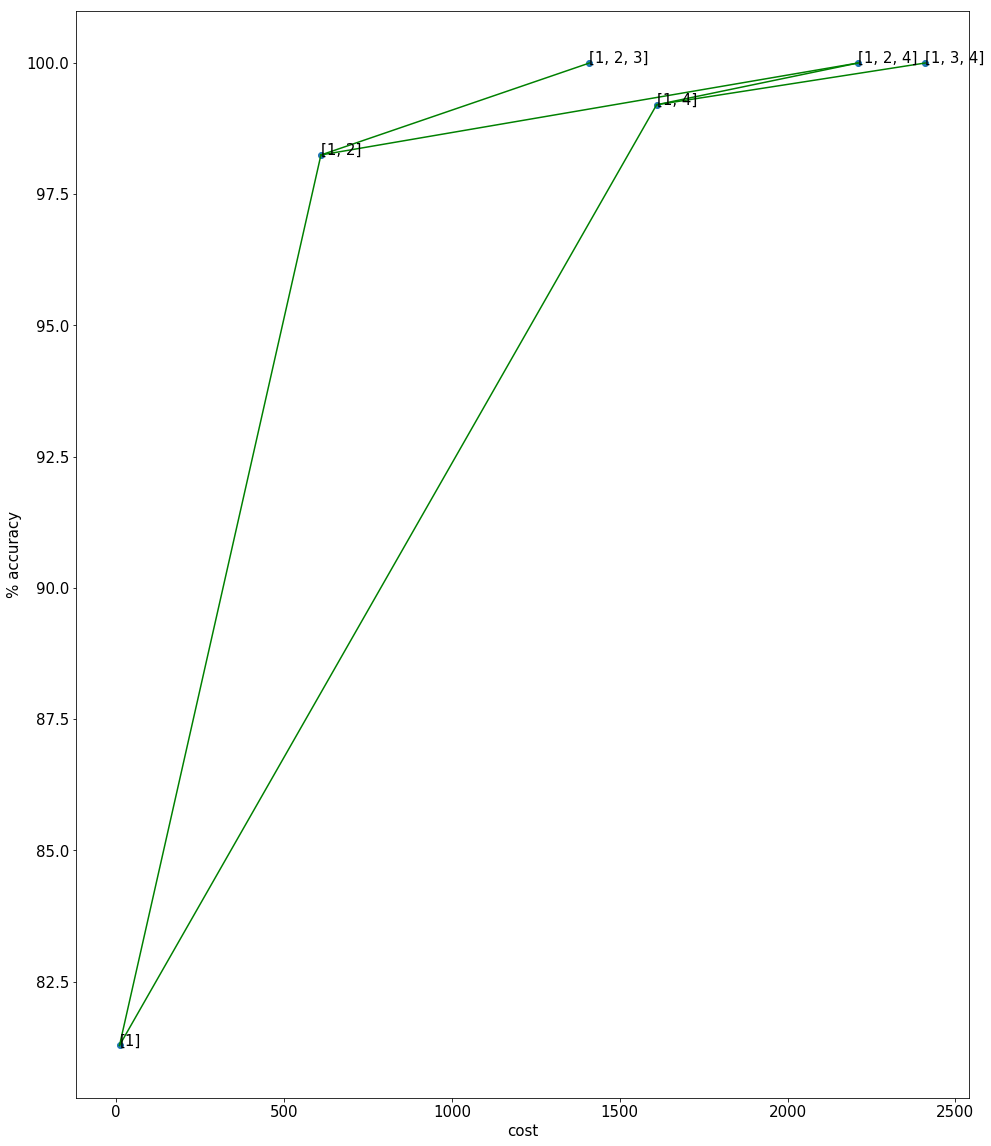

In [250]:
test_sample = list(index1&index2&index3&index4&index5&index6&index7&index8&index9&index0)

def cost_accuracy_model(size):
    pkl_files = {}
    for file in os.listdir(os.getcwd()):
        if file.startswith("all_meta_"):
            callers = file.split(".pkl")[0].split("_")
            if len(callers) == 3:
                pkl_files[tuple([callers[2]])] = file
            if len(callers) == 4:
                pkl_files[tuple([callers[2],callers[3]])] = file
    
    second_notzero = {}
    callers = [('muse',)]
    cost = [muse(size)]
    acc = []
    meta = pd.read_pickle("all_meta_muse.pkl", compression='bz2')
    percentages = 100*np.array(meta[list(meta.columns)[1]]) / np.array(meta[list(meta.columns)[5]])
    percentages = percentages[~np.isnan(percentages)]
    acc.append(np.average(percentages))
    for caller in possible_callers:
        if caller != 'muse':            
            co = muse(size)
            
            accuracy, label_pred, data_test, meta, add_caller_index, clf, index, drop = algo_plot(['muse'], [caller])
            
            test_features = np.array(data_test.loc[test_sample[1]])
            print(test_features)
            test = np.delete(test_features, drop)
            test2 = test.reshape(1, -1)
            pred = clf.predict(test2)
            print(pred) 
            if pred[0] == 1:
                not_zero_index = [i for i in range(len(label_pred)) if label_pred[i] == 1]
                top = np.array(data_test[list(data_test.columns)[add_caller_index[0]]])
                top = np.take(top, not_zero_index)
                bottom = np.array(data_test[list(data_test.columns)[5]])
                bottom = np.take(bottom, not_zero_index)
                ave = top/bottom
                ave = ave[~np.isnan(ave)]
                second_notzero[caller] = np.mean(ave)
                
                if caller == 'mutect':
                    co += mutect(size)
                if caller == 'muse':
                    co += muse(size)
                if caller == 'varscan':
                    co += varscan(size)
                if caller == 'somaticsniper':
                    co += somaticsniper(size)
                cost.append(co)
                acc.append(100*np.mean(ave))
                callers.append(('muse', caller))
    
    three_combs = my_combs(possible_callers, 3)
    plt.rcParams.update({'font.size': 15})
    matplotlib.rc('xtick', labelsize=15) 
    matplotlib.rc('ytick', labelsize=15) 
    plt.figure(figsize=(16,20))
    for i in three_combs:
        if 'muse' in i:
            co = 0
            if 'mutect' in i:
                co += mutect(size)
            if 'muse' in i:
                co += muse(size)
            if 'varscan' in i:
                co += varscan(size)
            if 'somaticsniper' in i:
                co += somaticsniper(size)
            cost.append(co)
            acc.append(100)
            callers.append(i)
        
    for i in range(len(cost)):
        if len(callers[i]) == 2 and callers[i][1] in second_notzero.keys():
            caller_x = (cost[0], cost[i])
            caller_y = (acc[0], acc[i])
            plt.plot(caller_x,caller_y, color = 'g')
    
    for i in range(len(cost)):
        if len(callers[i]) == 2:            
            for j in range(len(cost)):
                if len(callers[j]) == 3 and callers[i][0] in callers[j] and callers[i][1] in callers[j]:
                    caller_x = (cost[i], cost[j])
                    caller_y = (acc[i], acc[j])
                    plt.plot(caller_x,caller_y, color = 'g')
    plt.scatter(cost, acc)
    m = {'muse':1, 'mutect':2, 'somaticsniper':3, 'varscan':4}
    for j in range(len(callers)):
        save = callers[j]
        callers[j] = [m[x] for x in save]
    for i in range(len(cost)):
        plt.annotate(callers[i], (cost[i], acc[i]))
    print (cost, acc, callers)
    plt.xlabel("cost")
    plt.ylabel("% accuracy")
    plt.show()
    

cost_accuracy_model(20)


In [181]:
sampling_strat = {'muse':0,'mutect':0.75,'varscan':0.7,'somatisniper':0,['muse', 'mutect']:0.2,['muse', 'varscan']:0.0875,['muse', 'somaticsniper']:0,['mutect', 'varscan']:0.055,
                  ['mutect', 'somaticsniper']:0.2,['somaticsniper', 'varscan']:0.5}

TypeError: unhashable type: 'list'